# Ranking on undirected graphs

Here we check the ranking for undirected graphs, such as, the path graphs, cycle graphs, star graphs, wheel graphs, comlete graph, balanced tree, and barbell graph. 

## Programs

These programs are collected from the file "Ranking on nodes directed graph with damping factor.ipynb". Check that file for detailed description.

In [121]:
import math as math
import networkx as nx
import matplotlib.pyplot as plt
import scipy.linalg as lin
import numpy as np
import sympy as sym
from networkx.drawing.nx_pydot import graphviz_layout

In [122]:
pi = np.pi

In [123]:
def ket_vector(n, v):
    ket = [0] * n
    ket[v] = 1
    return np.matrix(ket).transpose()

In [124]:
def w_coeff(n, u_0, k):
    return(np.exp(2J*pi * u_0 * k / n))

In [125]:
def Weyl(n, u_0, u_l):
    z = np.matrix(np.zeros((n ,n)))
    for k in range(n):
        w = w_coeff(n, u_0, k)
        z = z + w * ket_vector(n, k) * ket_vector(n, (k + u_l) % n).transpose()
    return(z)

In [126]:
def make_directed(G):
    V = list(G.nodes())
    Vdict = {}
    for v in V:
        E = [(v, v)]
        for u in G.neighbors(v):
            E.append((v,u))
        Vdict[v] = E
    return(Vdict)

In [127]:
def Kraus_dictionary(G):
    n = G.order()
    Kdict = {}
    if type(G) == nx.classes.graph.Graph:
        G = G.to_directed()
    for u_0 in list(G.nodes()):
        d = G.out_degree(u_0) + 1
        Kdict[(u_0, u_0)] = np.matrix(np.eye(n))/math.sqrt(d)
        for u_l in G.neighbors(u_0):
            Kdict[(u_0, u_l)] = Weyl(n, u_0, u_l)/math.sqrt(d)
    return(Kdict)

In [128]:
def initial_state(G):
    n = G.order()
    I = np.matrix(np.eye(n))
    list_of_density_matrices = [I/n**2]*n
    return(list_of_density_matrices)

In [129]:
def evolve(G, IS, T):
    n = G.order()
    V = list(G.nodes())
    M = IS.copy()
    Kdict = Kraus_dictionary(G)
    for t in range(0, T):
#         print("t = ", t)
        L = [np.matrix(np.zeros((n , n)))]*n
        for i in range(n):
            u_0 = V[i]
            E = []
            E = list(G.in_edges(u_0)) + [(u_0, u_0)]
            for e in E:
                L[i] = L[i] + Kdict[e] * M[e[0]] * np.conjugate(Kdict[e]).transpose()
        P = []
        for i in range(n):
            M[i] = L[i]
            P.append(np.around(np.trace(M[i]), 4))
#         print(P)
    dic = {}
    for i in range(n):
        dic[i] = P[i]
    return(dic)

In [130]:
def evolve_with_damping(G, IS, T, alpha):
    n = G.order()
    V = list(G.nodes())
    M = IS.copy()
    Kdict = Kraus_dictionary(G)
    for t in range(0, T):
#         print("t = ", t)
        L = [np.matrix(np.zeros((n , n)))]*n
        for i in range(n):
            u_0 = V[i]
            E = []
            E = list(G.in_edges(u_0)) + [(u_0, u_0)]
            for e in E:
                L[i] = L[i] + Kdict[e] * M[e[0]] * np.conjugate(Kdict[e]).transpose()
        P = []
        Dump = sum(M)
        for i in range(n):
#             M[i] = L[i]
            M[i] = alpha * L[i] + (1 - alpha) * Dump / n
            P.append(np.around(np.trace(M[i]), 4))
#         print(P)
#     dic = {}
#     for i in range(n):
#         dic[i] = P[i]
    return(P)

In [131]:
def one_step_evolution(G, alpha, M):
    n = G.order()
    V = list(G.nodes())
    Kdict = Kraus_dictionary(G)
    L = [np.matrix(np.zeros((n , n)))]*n
    if type(G) == nx.classes.graph.Graph:
        G = G.to_directed()
    for i in range(n):
        u_0 = V[i]
        E = []
        E = list(G.in_edges(u_0)) + [(u_0, u_0)]
        for e in E:
            L[i] = L[i] + Kdict[e] * M[e[0]] * np.conjugate(Kdict[e]).transpose()
    Dump = sum(M)
    for i in range(n):
        L[i] = alpha * L[i] + (1 - alpha) * Dump / n
    return(L)

In [132]:
def find_probability(M):
    n = len(M)
    P = []
    for i in range(n):
        P.append(np.around(np.trace(M[i]), 4))
    return(P)

In [133]:
def q_rank(G, alpha):
    n = G.order()
    V = list(G.nodes())
    Kdict = Kraus_dictionary(G)
    IS = initial_state(G)
    M = IS.copy()
    P = []
    P = find_probability(M)
    Q = [1]*n
    t = 1
    while lin.norm(np.array(P) - np.array(Q)) >= .0001:
        P = []
        P = Q
#         print(P)
        L = one_step_evolution(G, .85, M)
        Q = []
        Q = find_probability(L)
#         print(Q)
        M = []
        M = L.copy()
        t = t + 1
    dic = {}
    for i in range(n):
        dic[i] = Q[i]
    return(dic, t)

In [134]:
def Google_matrix(G, alpha):
    n = G.order()
    if type(G) == nx.classes.graph.Graph:
        G = G.to_directed()
    O = np.ones(n)
    A = nx.adjacency_matrix(G).A
    S = np.zeros((n, n))
    for i in range(n):
        if G.out_degree(i) != 0:
            d = G.out_degree(i)
            S[i] = A[i]/d
        else:
            S[i] = np.ones(n)/n
    Google = alpha * S + (1 - alpha)*O/n
    return(Google)

In [135]:
def page_rank(G, alpha):
    Google = np.matrix(Google_matrix(G, alpha))
    n = G.order()
    w = np.ones(n) / n
    v = w*Google
    t = 1
    while np.linalg.norm(w - v) >= .0001:
        w = v
        v = w*Google
        t = t + 1
    dic = {}
    v = np.array(v)[0]
    for i in range(n):
        dic[i] = v[i]
    return(dic, t)
#     return(v)

## Examples on undirected graphs

### Path graph

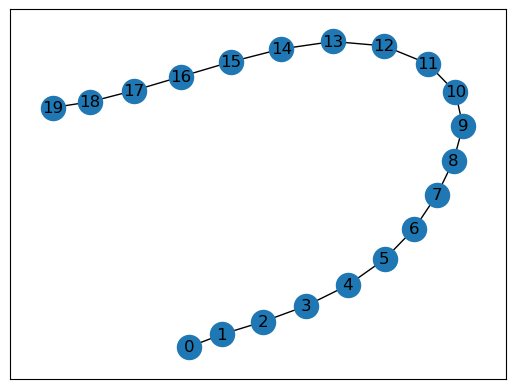

In [136]:
G = nx.path_graph(20)
nx.draw_networkx(G)

In [137]:
P, t = page_rank(G, .8)
P

/tmp/ipykernel_6965/3751517394.py:6: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G).A


{0: 0.033327198459403275,
 1: 0.05834724533923807,
 2: 0.05415526505414987,
 3: 0.05209513950975023,
 4: 0.05103276999584476,
 5: 0.05052968142188742,
 6: 0.0502559268191236,
 7: 0.0501380440556359,
 8: 0.05006988455676741,
 9: 0.05004884478820004,
 10: 0.05004884478820004,
 11: 0.05006988455676741,
 12: 0.050138044055635905,
 13: 0.0502559268191236,
 14: 0.05052968142188742,
 15: 0.051032769995844766,
 16: 0.05209513950975023,
 17: 0.05415526505414987,
 18: 0.05834724533923807,
 19: 0.033327198459403275}

In [138]:
t

25

In [139]:
Q, t = q_rank(G, .8)
Q

{0: (0.0402+0j),
 1: (0.0551+0j),
 2: (0.0525+0j),
 3: (0.0512+0j),
 4: (0.0506+0j),
 5: (0.0503+0j),
 6: (0.0501+0j),
 7: (0.05-0j),
 8: (0.05+0j),
 9: (0.05-0j),
 10: (0.05-0j),
 11: (0.05-0j),
 12: (0.05+0j),
 13: (0.0501+0j),
 14: (0.0503+0j),
 15: (0.0506+0j),
 16: (0.0512+0j),
 17: (0.0525-0j),
 18: (0.0551+0j),
 19: (0.0402+0j)}

In [140]:
t

14

In [141]:
P1 = np.real(list(P.values()))
P1

array([0.0333272 , 0.05834725, 0.05415527, 0.05209514, 0.05103277,
       0.05052968, 0.05025593, 0.05013804, 0.05006988, 0.05004884,
       0.05004884, 0.05006988, 0.05013804, 0.05025593, 0.05052968,
       0.05103277, 0.05209514, 0.05415527, 0.05834725, 0.0333272 ])

In [142]:
Q1 = np.real(list(Q.values()))
Q1

array([0.0402, 0.0551, 0.0525, 0.0512, 0.0506, 0.0503, 0.0501, 0.05  ,
       0.05  , 0.05  , 0.05  , 0.05  , 0.05  , 0.0501, 0.0503, 0.0506,
       0.0512, 0.0525, 0.0551, 0.0402])

In [143]:
X = list(G.nodes())
X

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

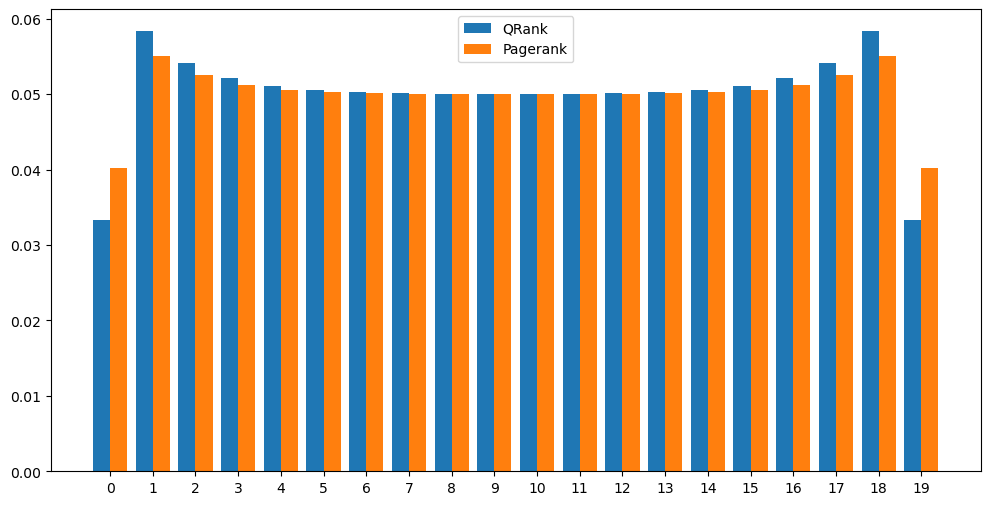

In [144]:
plt.figure(figsize=(12,6))
X_axis = np.arange(len(X))
plt.bar(X_axis - 0.2, P1, 0.4, label = 'QRank') 
plt.bar(X_axis + 0.2, Q1, 0.4, label = 'Pagerank')
plt.xticks(X_axis, X) 
plt.legend() 
plt.show() 

### Cycle graph

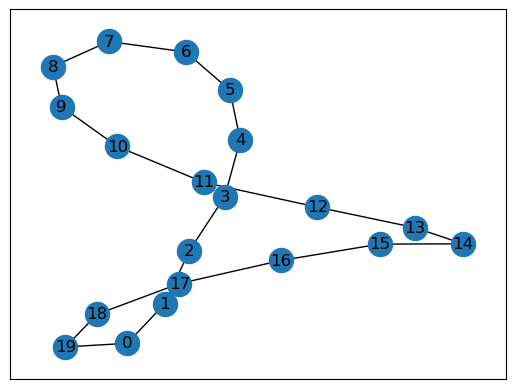

In [145]:
G = nx.cycle_graph(20)
nx.draw_networkx(G)

In [146]:
P, t = page_rank(G, .8)
P

/tmp/ipykernel_6965/3751517394.py:6: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G).A


{0: 0.05,
 1: 0.05000000000000002,
 2: 0.05000000000000002,
 3: 0.05000000000000002,
 4: 0.05000000000000002,
 5: 0.05000000000000002,
 6: 0.05000000000000002,
 7: 0.05000000000000001,
 8: 0.05000000000000001,
 9: 0.05000000000000001,
 10: 0.05000000000000001,
 11: 0.05000000000000001,
 12: 0.05000000000000001,
 13: 0.05000000000000001,
 14: 0.05000000000000001,
 15: 0.05,
 16: 0.05,
 17: 0.05000000000000001,
 18: 0.05000000000000001,
 19: 0.05}

In [147]:
t

1

In [148]:
Q, t = q_rank(G, .8)
Q

{0: (0.05+0j),
 1: (0.05-0j),
 2: (0.05+0j),
 3: (0.05-0j),
 4: (0.05+0j),
 5: (0.05+0j),
 6: (0.05-0j),
 7: (0.05-0j),
 8: (0.05-0j),
 9: (0.05-0j),
 10: (0.05-0j),
 11: (0.05+0j),
 12: (0.05-0j),
 13: (0.05+0j),
 14: (0.05-0j),
 15: (0.05+0j),
 16: (0.05+0j),
 17: (0.05+0j),
 18: (0.05-0j),
 19: (0.05-0j)}

In [149]:
t

3

In [150]:
P1 = np.real(list(P.values()))
P1

array([0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
       0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05])

In [151]:
Q1 = np.real(list(Q.values()))
Q1

array([0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
       0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05])

In [152]:
X = list(G.nodes())
X

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

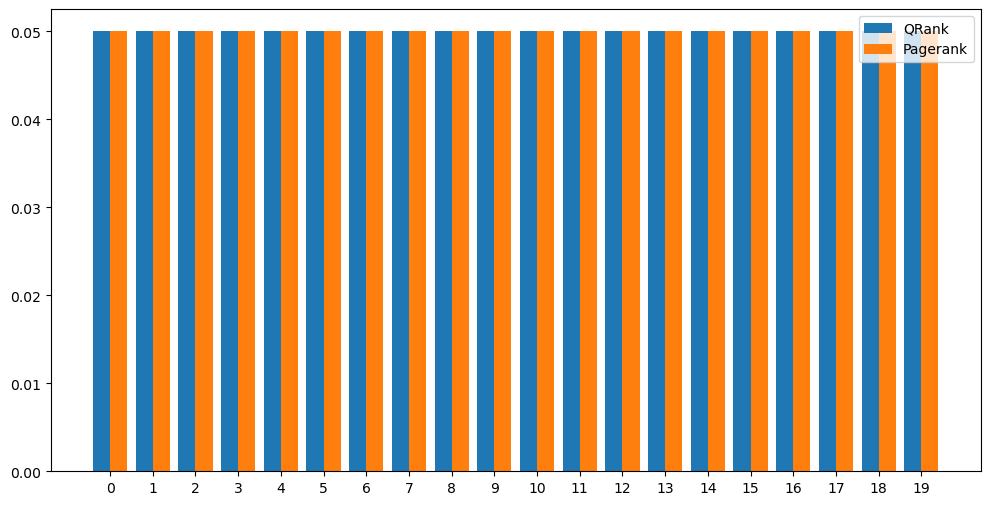

In [153]:
plt.figure(figsize=(12,6))
X_axis = np.arange(len(X))
plt.bar(X_axis - 0.2, P1, 0.4, label = 'QRank') 
plt.bar(X_axis + 0.2, Q1, 0.4, label = 'Pagerank')
plt.xticks(X_axis, X) 
plt.legend() 
plt.show() 

### Star graph

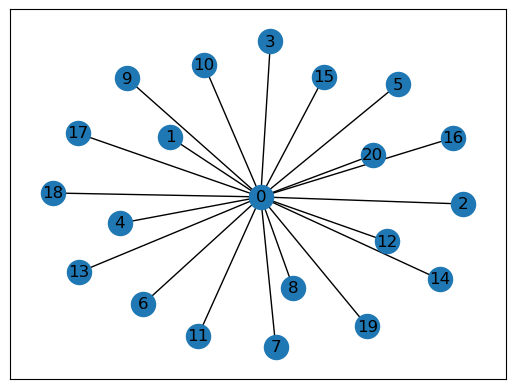

In [154]:
G = nx.star_graph(20)
nx.draw_networkx(G)

In [155]:
P, t = page_rank(G, .8)
P

/tmp/ipykernel_6965/3751517394.py:6: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G).A


{0: 0.4497782100857901,
 1: 0.027511089495710458,
 2: 0.027511089495710458,
 3: 0.027511089495710458,
 4: 0.027511089495710458,
 5: 0.027511089495710458,
 6: 0.027511089495710458,
 7: 0.027511089495710458,
 8: 0.027511089495710458,
 9: 0.027511089495710458,
 10: 0.027511089495710458,
 11: 0.027511089495710458,
 12: 0.027511089495710458,
 13: 0.027511089495710458,
 14: 0.027511089495710458,
 15: 0.027511089495710458,
 16: 0.027511089495710458,
 17: 0.027511089495710458,
 18: 0.027511089495710458,
 19: 0.027511089495710458,
 20: 0.02751108949571049}

In [156]:
t

41

In [157]:
Q, t = q_rank(G, .8)
Q

{0: (0.3121-0j),
 1: (0.0344+0j),
 2: (0.0344+0j),
 3: (0.0344+0j),
 4: (0.0344+0j),
 5: (0.0344+0j),
 6: (0.0344+0j),
 7: (0.0344+0j),
 8: (0.0344+0j),
 9: (0.0344+0j),
 10: (0.0344+0j),
 11: (0.0344+0j),
 12: (0.0344+0j),
 13: (0.0344+0j),
 14: (0.0344+0j),
 15: (0.0344+0j),
 16: (0.0344+0j),
 17: (0.0344+0j),
 18: (0.0344+0j),
 19: (0.0344+0j),
 20: (0.0344+0j)}

In [158]:
t

11

In [159]:
P1 = np.real(list(P.values()))
P1

array([0.44977821, 0.02751109, 0.02751109, 0.02751109, 0.02751109,
       0.02751109, 0.02751109, 0.02751109, 0.02751109, 0.02751109,
       0.02751109, 0.02751109, 0.02751109, 0.02751109, 0.02751109,
       0.02751109, 0.02751109, 0.02751109, 0.02751109, 0.02751109,
       0.02751109])

In [160]:
Q1 = np.real(list(Q.values()))
Q1

array([0.3121, 0.0344, 0.0344, 0.0344, 0.0344, 0.0344, 0.0344, 0.0344,
       0.0344, 0.0344, 0.0344, 0.0344, 0.0344, 0.0344, 0.0344, 0.0344,
       0.0344, 0.0344, 0.0344, 0.0344, 0.0344])

In [161]:
X = list(G.nodes())
X

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

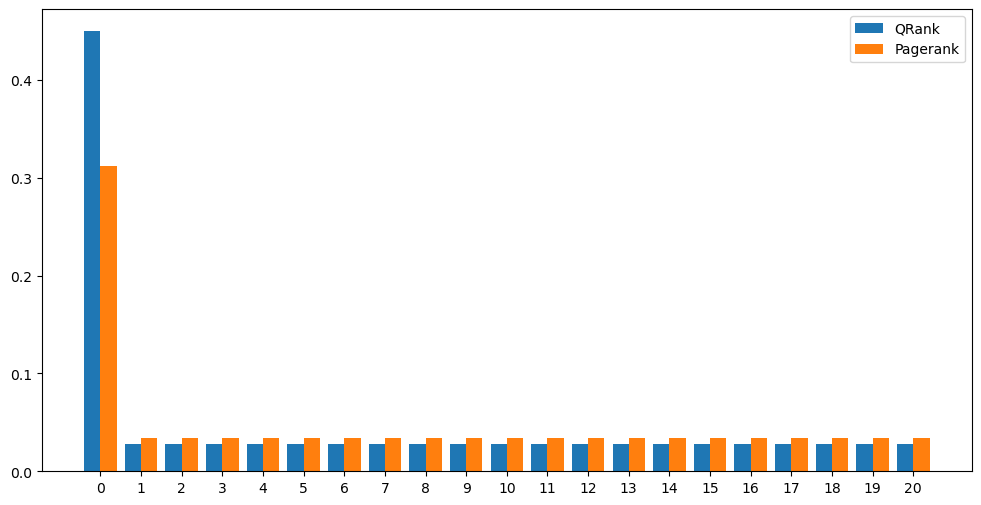

In [162]:
plt.figure(figsize=(12,6))
X_axis = np.arange(len(X))
plt.bar(X_axis - 0.2, P1, 0.4, label = 'QRank') 
plt.bar(X_axis + 0.2, Q1, 0.4, label = 'Pagerank')
plt.xticks(X_axis, X) 
plt.legend() 
plt.show() 

### Wheel graph

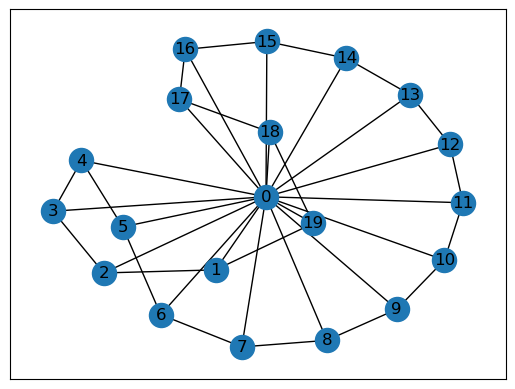

In [163]:
G = nx.wheel_graph(20)
nx.draw_networkx(G)

In [164]:
P, t = page_rank(G, .8)
P

/tmp/ipykernel_6965/3751517394.py:6: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G).A


{0: 0.21843720281664378,
 1: 0.0411348840622819,
 2: 0.0411348840622819,
 3: 0.0411348840622819,
 4: 0.0411348840622819,
 5: 0.04113488406228189,
 6: 0.04113488406228189,
 7: 0.0411348840622819,
 8: 0.0411348840622819,
 9: 0.0411348840622819,
 10: 0.0411348840622819,
 11: 0.0411348840622819,
 12: 0.0411348840622819,
 13: 0.0411348840622819,
 14: 0.0411348840622819,
 15: 0.0411348840622819,
 16: 0.0411348840622819,
 17: 0.0411348840622819,
 18: 0.0411348840622819,
 19: 0.0411348840622819}

In [165]:
t

7

In [166]:
Q, t = q_rank(G, .8)
Q

{0: (0.188+0j),
 1: (0.0427-0j),
 2: (0.0427+0j),
 3: (0.0427+0j),
 4: (0.0427-0j),
 5: (0.0427+0j),
 6: (0.0427+0j),
 7: (0.0427+0j),
 8: (0.0427+0j),
 9: (0.0427-0j),
 10: (0.0427+0j),
 11: (0.0427-0j),
 12: (0.0427+0j),
 13: (0.0427+0j),
 14: (0.0427+0j),
 15: (0.0427+0j),
 16: (0.0427+0j),
 17: (0.0427+0j),
 18: (0.0427+0j),
 19: (0.0427+0j)}

In [167]:
t

7

In [168]:
P1 = np.real(list(P.values()))
P1

array([0.2184372 , 0.04113488, 0.04113488, 0.04113488, 0.04113488,
       0.04113488, 0.04113488, 0.04113488, 0.04113488, 0.04113488,
       0.04113488, 0.04113488, 0.04113488, 0.04113488, 0.04113488,
       0.04113488, 0.04113488, 0.04113488, 0.04113488, 0.04113488])

In [169]:
Q1 = np.real(list(Q.values()))
Q1

array([0.188 , 0.0427, 0.0427, 0.0427, 0.0427, 0.0427, 0.0427, 0.0427,
       0.0427, 0.0427, 0.0427, 0.0427, 0.0427, 0.0427, 0.0427, 0.0427,
       0.0427, 0.0427, 0.0427, 0.0427])

In [170]:
X = list(G.nodes())
X

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

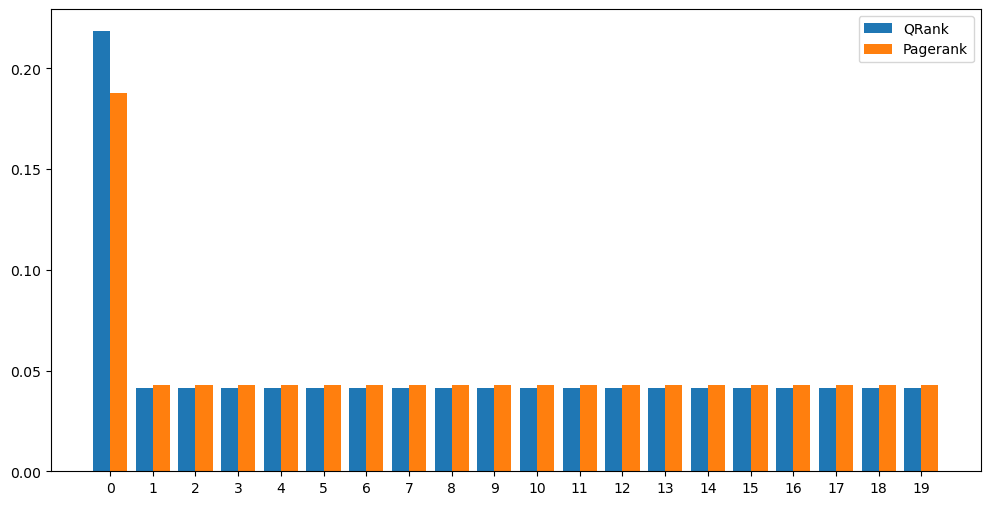

In [171]:
plt.figure(figsize=(12,6))
X_axis = np.arange(len(X))
plt.bar(X_axis - 0.2, P1, 0.4, label = 'QRank') 
plt.bar(X_axis + 0.2, Q1, 0.4, label = 'Pagerank')
plt.xticks(X_axis, X) 
plt.legend() 
plt.show() 

### Complete graph

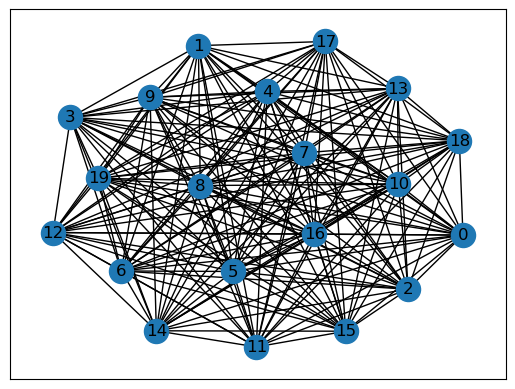

In [172]:
G = nx.complete_graph(20)
nx.draw_networkx(G)

In [173]:
P, t = page_rank(G, .8)
P

/tmp/ipykernel_6965/3751517394.py:6: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G).A


{0: 0.05000000000000001,
 1: 0.05000000000000001,
 2: 0.05000000000000001,
 3: 0.05000000000000001,
 4: 0.05000000000000001,
 5: 0.05000000000000001,
 6: 0.05000000000000001,
 7: 0.05000000000000001,
 8: 0.05000000000000001,
 9: 0.05000000000000001,
 10: 0.05000000000000001,
 11: 0.05000000000000001,
 12: 0.05000000000000001,
 13: 0.05000000000000001,
 14: 0.05000000000000001,
 15: 0.05000000000000001,
 16: 0.05,
 17: 0.05,
 18: 0.05000000000000001,
 19: 0.05000000000000001}

In [174]:
t

1

In [175]:
Q, t = q_rank(G, .8)
Q

{0: (0.05+0j),
 1: (0.05+0j),
 2: (0.05+0j),
 3: (0.05+0j),
 4: (0.05+0j),
 5: (0.05+0j),
 6: (0.05+0j),
 7: (0.05+0j),
 8: (0.05+0j),
 9: (0.05+0j),
 10: (0.05+0j),
 11: (0.05+0j),
 12: (0.05+0j),
 13: (0.05+0j),
 14: (0.05+0j),
 15: (0.05+0j),
 16: (0.05+0j),
 17: (0.05+0j),
 18: (0.05+0j),
 19: (0.05+0j)}

In [176]:
t

3

In [177]:
P1 = np.real(list(P.values()))
P1

array([0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
       0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05])

In [178]:
Q1 = np.real(list(Q.values()))
Q1

array([0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
       0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05])

In [179]:
X = list(G.nodes())
X

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

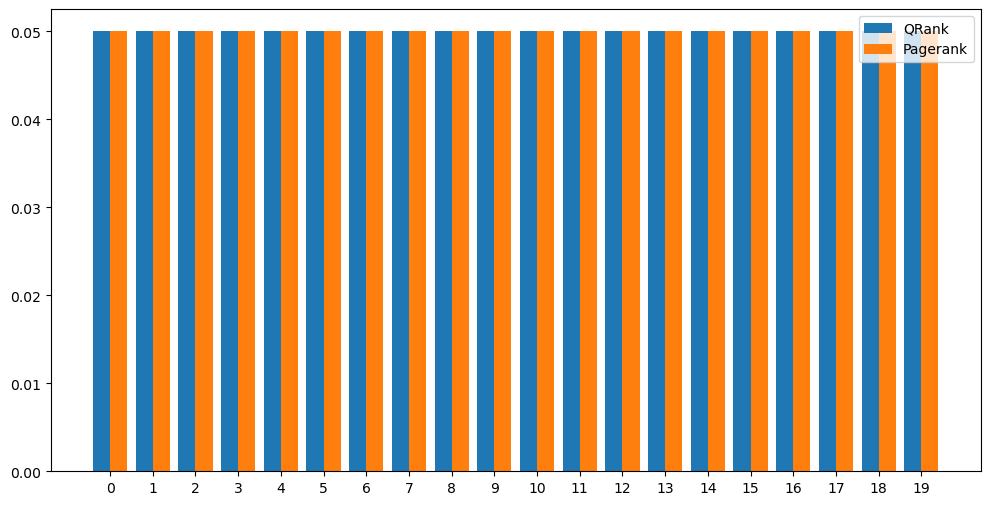

In [180]:
plt.figure(figsize=(12,6))
X_axis = np.arange(len(X))
plt.bar(X_axis - 0.2, P1, 0.4, label = 'QRank') 
plt.bar(X_axis + 0.2, Q1, 0.4, label = 'Pagerank')
plt.xticks(X_axis, X) 
plt.legend() 
plt.show() 

### Balanced Tree

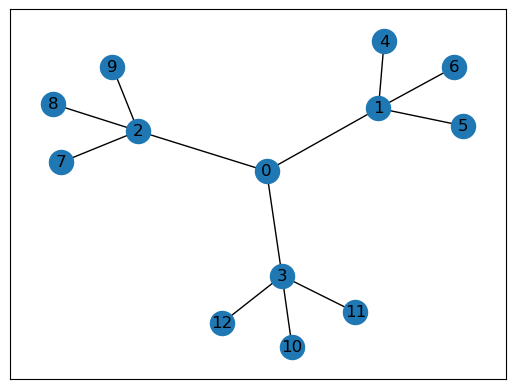

In [181]:
G = nx.balanced_tree(3,2)
nx.draw_networkx(G)

In [182]:
P, t = page_rank(G, .8)
P

/tmp/ipykernel_6965/3751517394.py:6: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G).A


{0: 0.10938617688973937,
 1: 0.15671586671111656,
 2: 0.1567158667111166,
 3: 0.15671586671111656,
 4: 0.046718469219656694,
 5: 0.046718469219656694,
 6: 0.046718469219656694,
 7: 0.0467184692196567,
 8: 0.0467184692196567,
 9: 0.0467184692196567,
 10: 0.0467184692196567,
 11: 0.0467184692196567,
 12: 0.0467184692196567}

In [183]:
t

37

In [184]:
Q, t = q_rank(G, .8)
Q

{0: (0.0973-0j),
 1: (0.1276-0j),
 2: (0.1276-0j),
 3: (0.1276-0j),
 4: (0.0578-0j),
 5: (0.0578-0j),
 6: (0.0578-0j),
 7: (0.0578-0j),
 8: (0.0578-0j),
 9: (0.0578-0j),
 10: (0.0578-0j),
 11: (0.0578+0j),
 12: (0.0578-0j)}

In [185]:
t

10

In [186]:
P1 = np.real(list(P.values()))
P1

array([0.10938618, 0.15671587, 0.15671587, 0.15671587, 0.04671847,
       0.04671847, 0.04671847, 0.04671847, 0.04671847, 0.04671847,
       0.04671847, 0.04671847, 0.04671847])

In [187]:
Q1 = np.real(list(Q.values()))
Q1

array([0.0973, 0.1276, 0.1276, 0.1276, 0.0578, 0.0578, 0.0578, 0.0578,
       0.0578, 0.0578, 0.0578, 0.0578, 0.0578])

In [188]:
X = list(G.nodes())
X

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

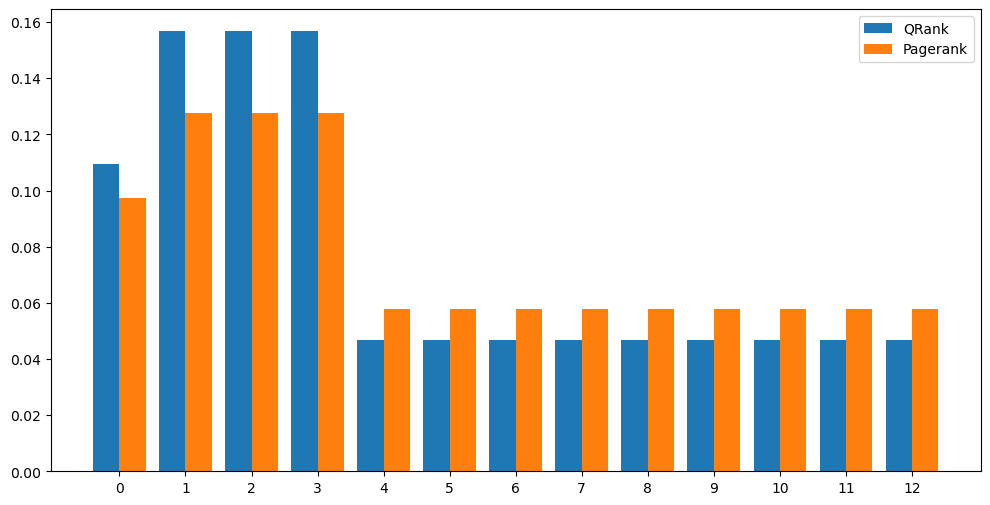

In [189]:
plt.figure(figsize=(12,6))
X_axis = np.arange(len(X))
plt.bar(X_axis - 0.2, P1, 0.4, label = 'QRank') 
plt.bar(X_axis + 0.2, Q1, 0.4, label = 'Pagerank')
plt.xticks(X_axis, X) 
plt.legend() 
plt.show() 

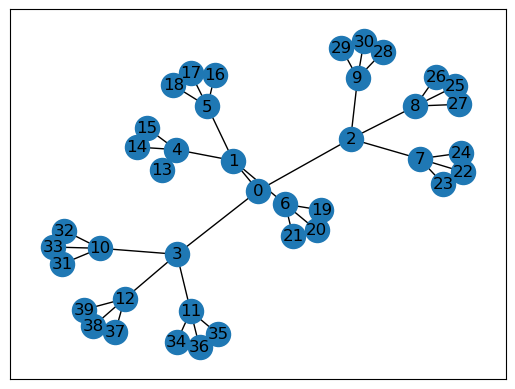

In [190]:
G = nx.balanced_tree(3,3)
nx.draw_networkx(G)

In [191]:
P, t = page_rank(G, .8)
P

/tmp/ipykernel_6965/3751517394.py:6: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G).A


{0: 0.030546887859143772,
 1: 0.0426041495211417,
 2: 0.04260414952114171,
 3: 0.04260414952114171,
 4: 0.04906251714552502,
 5: 0.04906251714552502,
 6: 0.04906251714552502,
 7: 0.04906251714552502,
 8: 0.04906251714552502,
 9: 0.04906251714552502,
 10: 0.04906251714552503,
 11: 0.04906251714552502,
 12: 0.04906251714552502,
 13: 0.01481770404695209,
 14: 0.01481770404695209,
 15: 0.01481770404695209,
 16: 0.014817704046952094,
 17: 0.014817704046952094,
 18: 0.014817704046952094,
 19: 0.014817704046952094,
 20: 0.014817704046952094,
 21: 0.014817704046952094,
 22: 0.014817704046952094,
 23: 0.014817704046952094,
 24: 0.014817704046952094,
 25: 0.014817704046952093,
 26: 0.014817704046952093,
 27: 0.014817704046952093,
 28: 0.014817704046952094,
 29: 0.014817704046952094,
 30: 0.014817704046952094,
 31: 0.014817704046952093,
 32: 0.014817704046952093,
 33: 0.014817704046952093,
 34: 0.014817704046952094,
 35: 0.014817704046952094,
 36: 0.014817704046952094,
 37: 0.014817704046952098,


In [192]:
t

34

In [193]:
Q, t = q_rank(G, .8)
Q

{0: (0.0284-0j),
 1: (0.0366-0j),
 2: (0.0366+0j),
 3: (0.0366-0j),
 4: (0.0404-0j),
 5: (0.0404+0j),
 6: (0.0404-0j),
 7: (0.0404-0j),
 8: (0.0404-0j),
 9: (0.0404+0j),
 10: (0.0404+0j),
 11: (0.0404-0j),
 12: (0.0404+0j),
 13: (0.0185-0j),
 14: (0.0185-0j),
 15: (0.0185-0j),
 16: (0.0185+0j),
 17: (0.0185+0j),
 18: (0.0185+0j),
 19: (0.0185-0j),
 20: (0.0185-0j),
 21: (0.0185-0j),
 22: (0.0185+0j),
 23: (0.0185+0j),
 24: (0.0185+0j),
 25: (0.0185-0j),
 26: (0.0185-0j),
 27: (0.0185-0j),
 28: (0.0185-0j),
 29: (0.0185+0j),
 30: (0.0185+0j),
 31: (0.0185-0j),
 32: (0.0185-0j),
 33: (0.0185-0j),
 34: (0.0185-0j),
 35: (0.0185-0j),
 36: (0.0185-0j),
 37: (0.0185-0j),
 38: (0.0185-0j),
 39: (0.0185-0j)}

In [194]:
t

10

In [195]:
P1 = np.real(list(P.values()))
P1

array([0.03054689, 0.04260415, 0.04260415, 0.04260415, 0.04906252,
       0.04906252, 0.04906252, 0.04906252, 0.04906252, 0.04906252,
       0.04906252, 0.04906252, 0.04906252, 0.0148177 , 0.0148177 ,
       0.0148177 , 0.0148177 , 0.0148177 , 0.0148177 , 0.0148177 ,
       0.0148177 , 0.0148177 , 0.0148177 , 0.0148177 , 0.0148177 ,
       0.0148177 , 0.0148177 , 0.0148177 , 0.0148177 , 0.0148177 ,
       0.0148177 , 0.0148177 , 0.0148177 , 0.0148177 , 0.0148177 ,
       0.0148177 , 0.0148177 , 0.0148177 , 0.0148177 , 0.0148177 ])

In [196]:
Q1 = np.real(list(Q.values()))
Q1

array([0.0284, 0.0366, 0.0366, 0.0366, 0.0404, 0.0404, 0.0404, 0.0404,
       0.0404, 0.0404, 0.0404, 0.0404, 0.0404, 0.0185, 0.0185, 0.0185,
       0.0185, 0.0185, 0.0185, 0.0185, 0.0185, 0.0185, 0.0185, 0.0185,
       0.0185, 0.0185, 0.0185, 0.0185, 0.0185, 0.0185, 0.0185, 0.0185,
       0.0185, 0.0185, 0.0185, 0.0185, 0.0185, 0.0185, 0.0185, 0.0185])

In [197]:
X = list(G.nodes())
X

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39]

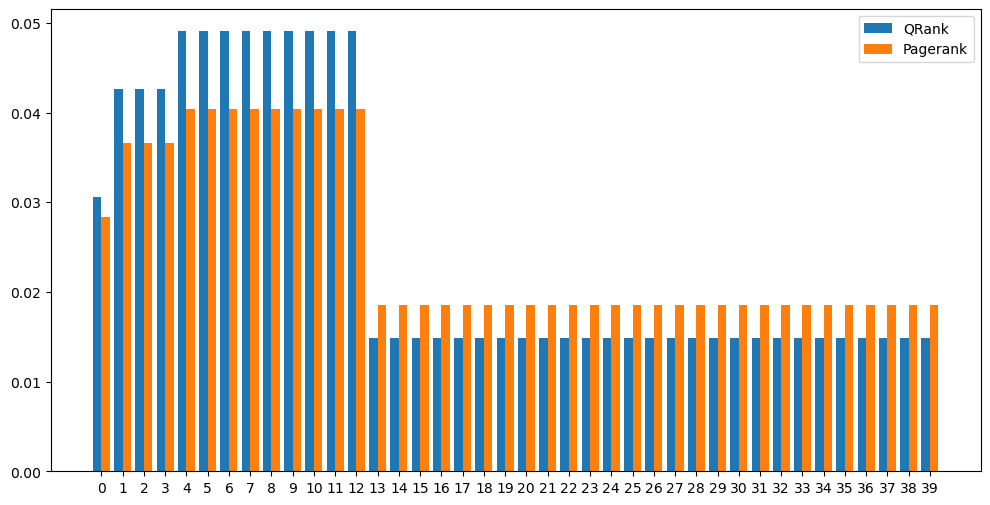

In [198]:
plt.figure(figsize=(12,6))
X_axis = np.arange(len(X))
plt.bar(X_axis - 0.2, P1, 0.4, label = 'QRank') 
plt.bar(X_axis + 0.2, Q1, 0.4, label = 'Pagerank')
plt.xticks(X_axis, X) 
plt.legend() 
plt.show() 

### Barbell Graph

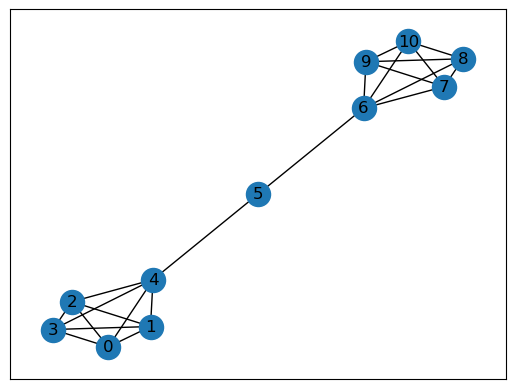

In [199]:
G = nx.barbell_graph(5,1)
nx.draw_networkx(G)

Our PageRank program fails to find the PageRank of the Barbell graph. We use the library function for calculating PageRank available in Networkx.

In [200]:
P, t = page_rank(G, .8)
P

/tmp/ipykernel_6965/3751517394.py:6: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G).A
/tmp/ipykernel_6965/403260630.py:7: RuntimeWarning: invalid value encountered in subtract
  while np.linalg.norm(w - v) >= .0001:


{0: inf,
 1: inf,
 2: inf,
 3: inf,
 4: inf,
 5: inf,
 6: inf,
 7: inf,
 8: inf,
 9: inf,
 10: inf}

In [201]:
P = nx.pagerank(G)
P

{0: 0.0903842745416981,
 1: 0.0903842745416981,
 2: 0.0903842745416981,
 3: 0.0903842745416981,
 4: 0.11251663096087657,
 6: 0.11251663096087658,
 7: 0.09038427454169812,
 8: 0.09038427454169812,
 9: 0.09038427454169812,
 10: 0.09038427454169812,
 5: 0.05189254174466203}

In [202]:
P = dict(sorted(P.items()))
P

{0: 0.0903842745416981,
 1: 0.0903842745416981,
 2: 0.0903842745416981,
 3: 0.0903842745416981,
 4: 0.11251663096087657,
 5: 0.05189254174466203,
 6: 0.11251663096087658,
 7: 0.09038427454169812,
 8: 0.09038427454169812,
 9: 0.09038427454169812,
 10: 0.09038427454169812}

In [203]:
Q, t = q_rank(G, .8)
Q

{0: (0.0997+0j),
 1: (0.0997-0j),
 2: (0.0997+0j),
 3: (0.0997+0j),
 4: (0.129-0j),
 5: (0.1036+0j),
 6: (0.0742-0j),
 7: (0.0742+0j),
 8: (0.0742+0j),
 9: (0.0742+0j),
 10: (0.0718+0j)}

In [204]:
t

21

In [205]:
P1 = np.real(list(P.values()))
P1

array([0.09038427, 0.09038427, 0.09038427, 0.09038427, 0.11251663,
       0.05189254, 0.11251663, 0.09038427, 0.09038427, 0.09038427,
       0.09038427])

In [206]:
Q1 = np.real(list(Q.values()))
Q1

array([0.0997, 0.0997, 0.0997, 0.0997, 0.129 , 0.1036, 0.0742, 0.0742,
       0.0742, 0.0742, 0.0718])

In [207]:
X = sorted(list(G.nodes()))
X

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

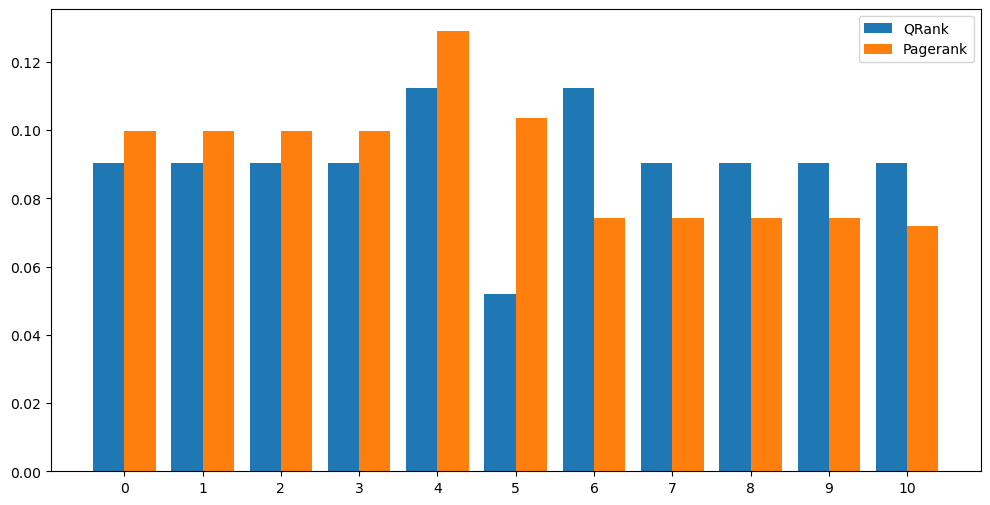

In [208]:
plt.figure(figsize=(12,6))
X_axis = np.arange(len(X))
plt.bar(X_axis - 0.2, P1, 0.4, label = 'QRank') 
plt.bar(X_axis + 0.2, Q1, 0.4, label = 'Pagerank')
plt.xticks(X_axis, X) 
plt.legend() 
plt.show() 

### Watts-Strogatz model

Duncan J. Watts and Steven H. Strogatz, Collective dynamics of small-world networks, Nature, 393, pp. 440–442, 1998.

https://networkx.org/documentation/stable/reference/generated/networkx.generators.random_graphs.watts_strogatz_graph.html

Here the graph may have loops in the vertices. We remove the loops after generating the graph. Also, we calculate the ranks for connected graphs only.

In [209]:
G = nx.watts_strogatz_graph(20, 3, .1, seed=None)
G.remove_edges_from(nx.selfloop_edges(G))

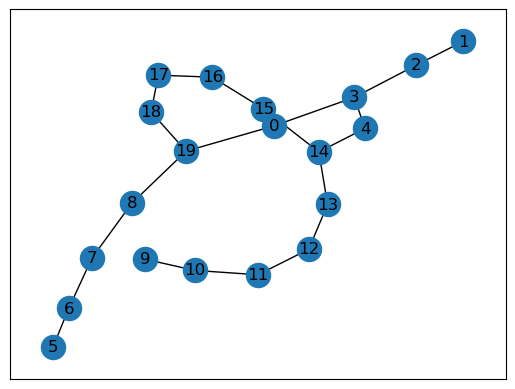

In [210]:
nx.draw_networkx(G)

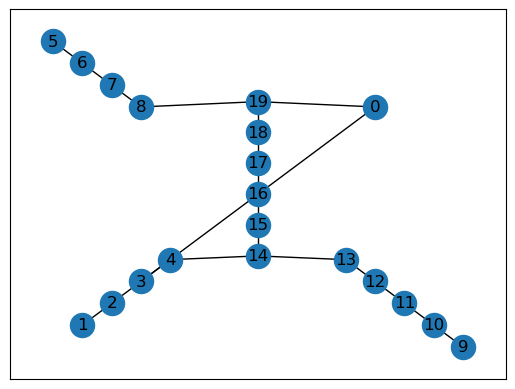

In [211]:
pos = graphviz_layout(G, prog="twopi")
nx.draw_networkx(G, pos)
plt.show()

In [212]:
P, t = page_rank(G, .85)
P

/tmp/ipykernel_6965/3751517394.py:6: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G).A


{0: 0.046373706257819475,
 1: 0.029764321005040558,
 2: 0.05237675814503112,
 3: 0.06912560735381333,
 4: 0.046222985091322666,
 5: 0.03154815559117219,
 6: 0.05659223833585983,
 7: 0.05239824245504089,
 8: 0.04906468359717633,
 9: 0.03180548688500365,
 10: 0.05722854307064654,
 11: 0.053319794336712564,
 12: 0.050654361160466024,
 13: 0.04815582144865903,
 14: 0.06758904515198705,
 15: 0.04694706820990764,
 16: 0.047792844107783033,
 17: 0.04783037845493855,
 18: 0.0471249746384417,
 19: 0.06808498470317831}

In [213]:
t

33

In [214]:
Q, t = q_rank(G, .85)
Q

{0: (0.0469-0j),
 1: (0.0385-0j),
 2: (0.0516-0j),
 3: (0.0618-0j),
 4: (0.0469-0j),
 5: (0.0399+0j),
 6: (0.0544-0j),
 7: (0.0513+0j),
 8: (0.0489-0j),
 9: (0.04-0j),
 10: (0.0548-0j),
 11: (0.0519-0j),
 12: (0.0501-0j),
 13: (0.0483-0j),
 14: (0.0609-0j),
 15: (0.0477-0j),
 16: (0.0485-0j),
 17: (0.0485-0j),
 18: (0.0478-0j),
 19: (0.0612-0j)}

In [215]:
t

16

In [216]:
P1 = np.real(list(P.values()))
P1

array([0.04637371, 0.02976432, 0.05237676, 0.06912561, 0.04622299,
       0.03154816, 0.05659224, 0.05239824, 0.04906468, 0.03180549,
       0.05722854, 0.05331979, 0.05065436, 0.04815582, 0.06758905,
       0.04694707, 0.04779284, 0.04783038, 0.04712497, 0.06808498])

In [217]:
Q1 = np.real(list(Q.values()))
Q1

array([0.0469, 0.0385, 0.0516, 0.0618, 0.0469, 0.0399, 0.0544, 0.0513,
       0.0489, 0.04  , 0.0548, 0.0519, 0.0501, 0.0483, 0.0609, 0.0477,
       0.0485, 0.0485, 0.0478, 0.0612])

In [218]:
X = list(G.nodes())
X

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

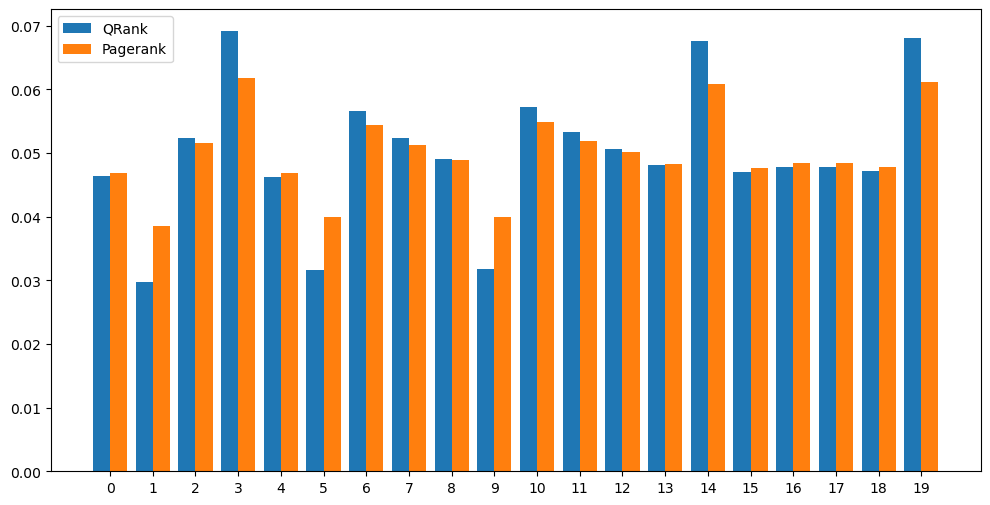

In [219]:
plt.figure(figsize=(12,6))
X_axis = np.arange(len(X))
plt.bar(X_axis - 0.2, P1, 0.4, label = 'QRank') 
plt.bar(X_axis + 0.2, Q1, 0.4, label = 'Pagerank')
plt.xticks(X_axis, X) 
plt.legend() 
plt.show() 

### Karate Club

Zachary W. (1977). An information flow model for conflict and fission in small groups. Journal of Anthropological Research, 33, 452-473.

https://networkx.org/documentation/stable/auto_examples/graph/plot_karate_club.html

In [220]:
G = nx.karate_club_graph()
# G.remove_edges_from(nx.selfloop_edges(G))

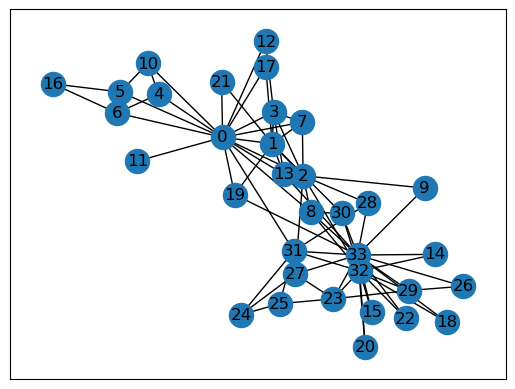

In [221]:
nx.draw_networkx(G)

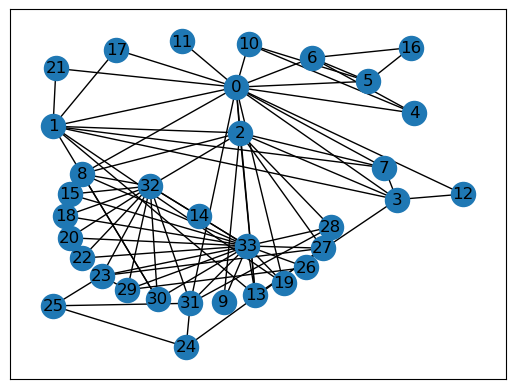

In [222]:
pos = graphviz_layout(G, prog="twopi")
nx.draw_networkx(G, pos)
plt.show()

Our program fails to calculate the PageRank. Hence, we use the inbuilt function.

In [223]:
P= nx.pagerank(G, .85)
P

{0: 0.08850807396280012,
 1: 0.057414840497110056,
 2: 0.06276686454603017,
 3: 0.03721208153631377,
 4: 0.020503977347501652,
 5: 0.03381044255357727,
 6: 0.03152901134345504,
 7: 0.026464618678806107,
 8: 0.03338155566846444,
 9: 0.009463219565799959,
 10: 0.020689016083505596,
 11: 0.009785686547904305,
 12: 0.011474872305945287,
 13: 0.033474187085322404,
 14: 0.012941600888556285,
 15: 0.01637633262359366,
 16: 0.016755401561857987,
 17: 0.009677265915396801,
 18: 0.009544864590131914,
 19: 0.013077518431081969,
 20: 0.011224235021037596,
 21: 0.01136015256356328,
 22: 0.01296059860686279,
 23: 0.04114596964602211,
 24: 0.01663437445025268,
 25: 0.028672962013730707,
 26: 0.015240392773380823,
 27: 0.027235358397633882,
 28: 0.01447852177427162,
 29: 0.028271813832825125,
 30: 0.02303184425091186,
 31: 0.04198548926127872,
 32: 0.07592643687005646,
 33: 0.09698041880501741}

In [224]:
Q, t = q_rank(G, .85)
Q

{0: (0.0834+0j),
 1: (0.0479-0j),
 2: (0.0513-0j),
 3: (0.0342+0j),
 4: (0.0236+0j),
 5: (0.0292+0j),
 6: (0.0292+0j),
 7: (0.025-0j),
 8: (0.0292-0j),
 9: (0.0174+0j),
 10: (0.0236+0j),
 11: (0.0149+0j),
 12: (0.0178-0j),
 13: (0.029-0j),
 14: (0.0177-0j),
 15: (0.0177-0j),
 16: (0.02+0j),
 17: (0.0177-0j),
 18: (0.0177-0j),
 19: (0.0213-0j),
 20: (0.0177-0j),
 21: (0.0177-0j),
 22: (0.0177+0j),
 23: (0.0308-0j),
 24: (0.0228-0j),
 25: (0.0228+0j),
 26: (0.0182+0j),
 27: (0.0261-0j),
 28: (0.0213+0j),
 29: (0.0267+0j),
 30: (0.0251-0j),
 31: (0.0353-0j),
 32: (0.0632-0j),
 33: (0.087-0j)}

In [225]:
t

15

In [226]:
P1 = np.real(list(P.values()))
P1

array([0.08850807, 0.05741484, 0.06276686, 0.03721208, 0.02050398,
       0.03381044, 0.03152901, 0.02646462, 0.03338156, 0.00946322,
       0.02068902, 0.00978569, 0.01147487, 0.03347419, 0.0129416 ,
       0.01637633, 0.0167554 , 0.00967727, 0.00954486, 0.01307752,
       0.01122424, 0.01136015, 0.0129606 , 0.04114597, 0.01663437,
       0.02867296, 0.01524039, 0.02723536, 0.01447852, 0.02827181,
       0.02303184, 0.04198549, 0.07592644, 0.09698042])

In [227]:
Q1 = np.real(list(Q.values()))
Q1

array([0.0834, 0.0479, 0.0513, 0.0342, 0.0236, 0.0292, 0.0292, 0.025 ,
       0.0292, 0.0174, 0.0236, 0.0149, 0.0178, 0.029 , 0.0177, 0.0177,
       0.02  , 0.0177, 0.0177, 0.0213, 0.0177, 0.0177, 0.0177, 0.0308,
       0.0228, 0.0228, 0.0182, 0.0261, 0.0213, 0.0267, 0.0251, 0.0353,
       0.0632, 0.087 ])

In [228]:
X = list(G.nodes())
X

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33]

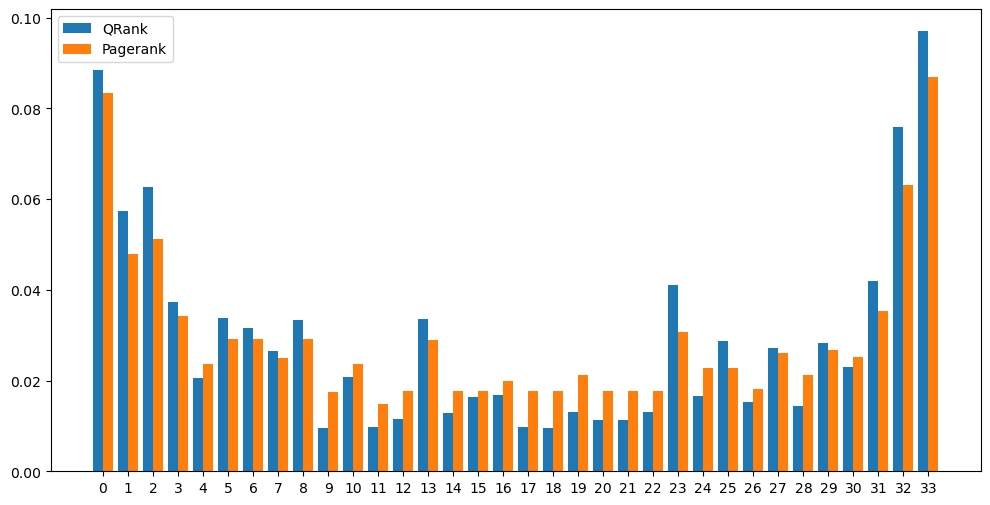

In [229]:
plt.figure(figsize=(12,6))
X_axis = np.arange(len(X))
plt.bar(X_axis - 0.2, P1, 0.4, label = 'QRank') 
plt.bar(X_axis + 0.2, Q1, 0.4, label = 'Pagerank')
plt.xticks(X_axis, X) 
plt.legend() 
plt.show() 

### Barabási and Albert model

A. L. Barabási and R. Albert “Emergence of scaling in random networks”, Science 286, pp 509-512, 1999.

https://networkx.org/documentation/stable/reference/generated/networkx.generators.random_graphs.barabasi_albert_graph.html

In [230]:
G = nx.barabasi_albert_graph(20, 3, seed=None, initial_graph=None)
# G.remove_edges_from(nx.selfloop_edges(G))

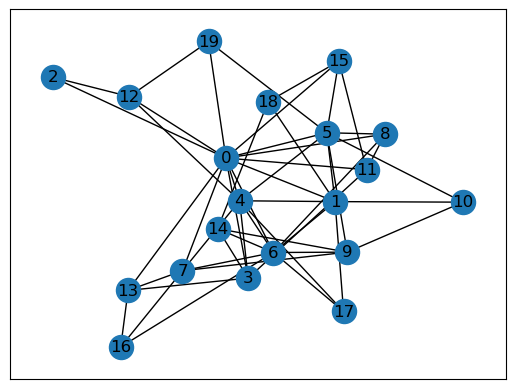

In [231]:
nx.draw_networkx(G)

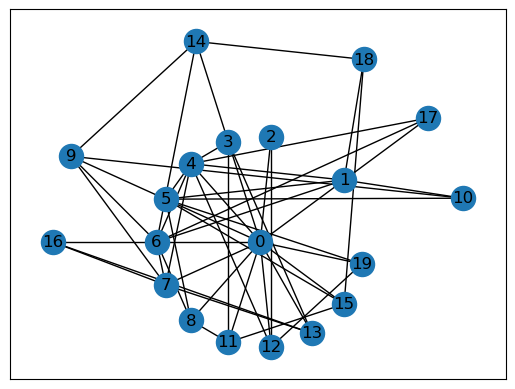

In [232]:
pos = graphviz_layout(G, prog="twopi")
nx.draw_networkx(G, pos)
plt.show()

Our program fails to calculate the PageRank. Hence, we use the inbuilt function.

In [233]:
(P, t) = page_rank(G, .85)
P

/tmp/ipykernel_6965/3751517394.py:6: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G).A


{0: 0.11834581208793517,
 1: 0.06589727763573129,
 2: 0.02425390911026259,
 3: 0.04911078337436907,
 4: 0.07318197554987091,
 5: 0.07466527887915178,
 6: 0.08249010865209974,
 7: 0.056861278376080154,
 8: 0.03961576330267064,
 9: 0.04906287710119592,
 10: 0.03177525093766799,
 11: 0.04076404074188017,
 12: 0.04245101170764134,
 13: 0.040705981065297325,
 14: 0.041338255136812,
 15: 0.04118536249429987,
 16: 0.03199418631096762,
 17: 0.03107068105326435,
 18: 0.033046442805866695,
 19: 0.03218372367693606}

In [234]:
t

11

In [235]:
Q, t = q_rank(G, .85)
Q

{0: (0.106+0j),
 1: (0.0628-0j),
 2: (0.0299-0j),
 3: (0.0491+0j),
 4: (0.0687-0j),
 5: (0.07-0j),
 6: (0.0764-0j),
 7: (0.0553-0j),
 8: (0.0413+0j),
 9: (0.0491-0j),
 10: (0.0352-0j),
 11: (0.0424-0j),
 12: (0.0439-0j),
 13: (0.0423+0j),
 14: (0.043-0j),
 15: (0.0428+0j),
 16: (0.0354+0j),
 17: (0.0345-0j),
 18: (0.0365-0j),
 19: (0.0356-0j)}

In [236]:
t

12

In [237]:
P1 = np.real(list(P.values()))
P1

array([0.11834581, 0.06589728, 0.02425391, 0.04911078, 0.07318198,
       0.07466528, 0.08249011, 0.05686128, 0.03961576, 0.04906288,
       0.03177525, 0.04076404, 0.04245101, 0.04070598, 0.04133826,
       0.04118536, 0.03199419, 0.03107068, 0.03304644, 0.03218372])

In [238]:
Q1 = np.real(list(Q.values()))
Q1

array([0.106 , 0.0628, 0.0299, 0.0491, 0.0687, 0.07  , 0.0764, 0.0553,
       0.0413, 0.0491, 0.0352, 0.0424, 0.0439, 0.0423, 0.043 , 0.0428,
       0.0354, 0.0345, 0.0365, 0.0356])

In [239]:
X = list(G.nodes())
X

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

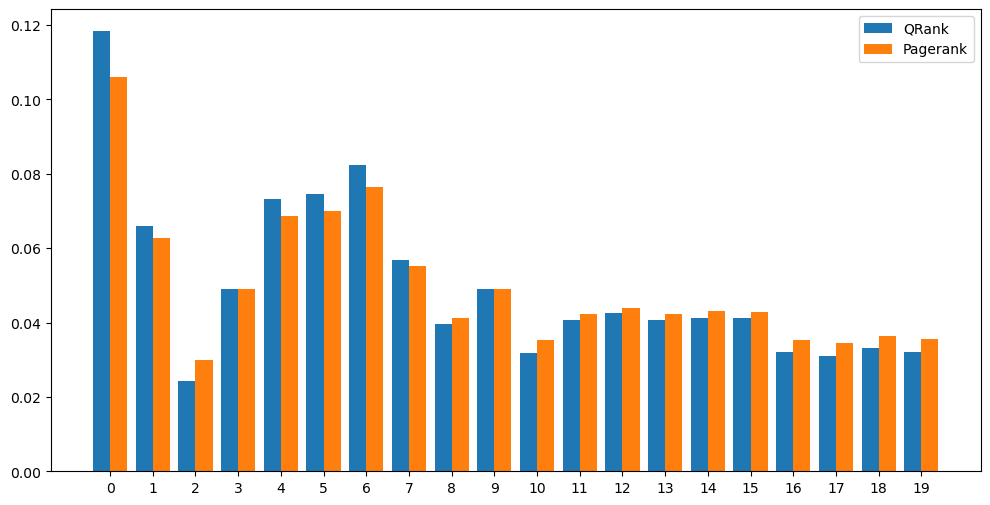

In [240]:
plt.figure(figsize=(12,6))
X_axis = np.arange(len(X))
plt.bar(X_axis - 0.2, P1, 0.4, label = 'QRank') 
plt.bar(X_axis + 0.2, Q1, 0.4, label = 'Pagerank')
plt.xticks(X_axis, X) 
plt.legend() 
plt.show() 

### Watts-Strogatz model

Duncan J. Watts and Steven H. Strogatz, Collective dynamics of small-world networks, Nature, 393, pp. 440–442, 1998.

https://networkx.org/documentation/stable/reference/generated/networkx.generators.random_graphs.watts_strogatz_graph.html

Here the graph may have loops in the vertices. We remove the loops after generating the graph. Also, we calculate the ranks for connected graphs only.

In [241]:
G = nx.watts_strogatz_graph(20, 3, .1, seed=None)
G.remove_edges_from(nx.selfloop_edges(G))
# nx.is_weakly_connected(G)

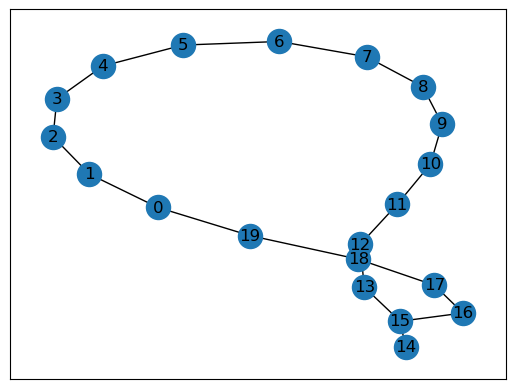

In [242]:
nx.draw_networkx(G)

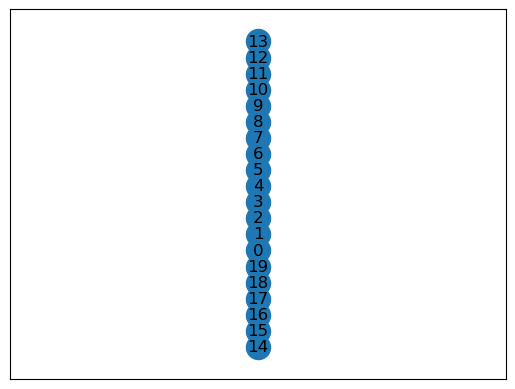

In [243]:
pos = graphviz_layout(G, prog="twopi")
nx.draw_networkx(G, pos)
plt.show()

In [244]:
P, t = page_rank(G, .85)
P

/tmp/ipykernel_6965/3751517394.py:6: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G).A


{0: 0.04996205259690661,
 1: 0.049968496483560915,
 2: 0.04998948359361578,
 3: 0.049988271891814186,
 4: 0.04999407774152643,
 5: 0.04999407774152642,
 6: 0.04998827189181417,
 7: 0.04998948359361578,
 8: 0.04996849648356091,
 9: 0.049962052596906614,
 10: 0.04990972946031459,
 11: 0.049864320092121564,
 12: 0.04972675461002738,
 13: 0.049541436602929353,
 14: 0.028397074840746994,
 15: 0.07371367901361993,
 16: 0.049541436602929353,
 17: 0.049726754610027395,
 18: 0.049864320092121564,
 19: 0.04990972946031459}

In [245]:
t

34

In [246]:
Q, t = q_rank(G, .85)
Q

{0: (0.05+0j),
 1: (0.05-0j),
 2: (0.05+0j),
 3: (0.05+0j),
 4: (0.05+0j),
 5: (0.05+0j),
 6: (0.05+0j),
 7: (0.05-0j),
 8: (0.05+0j),
 9: (0.05+0j),
 10: (0.0499-0j),
 11: (0.0498+0j),
 12: (0.0497+0j),
 13: (0.0494+0j),
 14: (0.0372-0j),
 15: (0.0652-0j),
 16: (0.0494-0j),
 17: (0.0497+0j),
 18: (0.0498+0j),
 19: (0.0499+0j)}

In [247]:
t

8

In [248]:
P1 = np.real(list(P.values()))
P1

array([0.04996205, 0.0499685 , 0.04998948, 0.04998827, 0.04999408,
       0.04999408, 0.04998827, 0.04998948, 0.0499685 , 0.04996205,
       0.04990973, 0.04986432, 0.04972675, 0.04954144, 0.02839707,
       0.07371368, 0.04954144, 0.04972675, 0.04986432, 0.04990973])

In [249]:
Q1 = np.real(list(Q.values()))
Q1

array([0.05  , 0.05  , 0.05  , 0.05  , 0.05  , 0.05  , 0.05  , 0.05  ,
       0.05  , 0.05  , 0.0499, 0.0498, 0.0497, 0.0494, 0.0372, 0.0652,
       0.0494, 0.0497, 0.0498, 0.0499])

In [250]:
X = list(G.nodes())
X

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

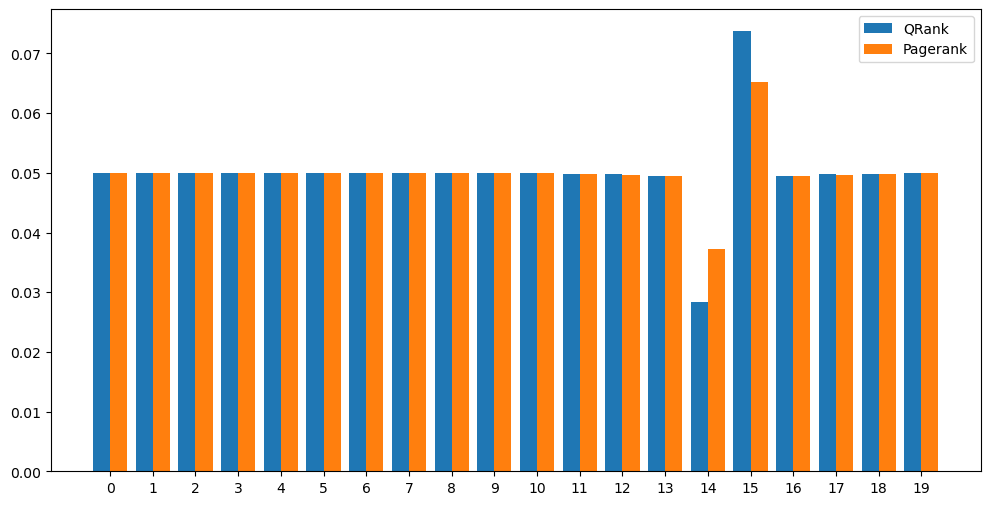

In [251]:
plt.figure(figsize=(12,6))
X_axis = np.arange(len(X))
plt.bar(X_axis - 0.2, P1, 0.4, label = 'QRank') 
plt.bar(X_axis + 0.2, Q1, 0.4, label = 'Pagerank')
plt.xticks(X_axis, X) 
plt.legend() 
plt.show() 